Import the necessary libraries

In [17]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy as copy
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

from keras.models import Sequential
from keras.layers import Activation, Dense
from keras import optimizers
from keras.layers import Flatten
from keras.utils.np_utils import to_categorical
from keras.layers import BatchNormalization, Dropout

In [74]:
#open the input file as read only
h5f = h5py.File('SVHN_single_grey1.h5', 'r')

In [75]:
#load the training, test and validation set
X_train = h5f['X_train'][:]
y_train = h5f['y_train'][:]
X_test = h5f['X_test'][:]
y_test = h5f['y_test'][:]
X_val = h5f['X_val'][:]
y_val = h5f['y_val'][:]

In [76]:
#close this file
h5f.close()

In [77]:
print('The shape of input features - training dataset :', X_train.shape)
print('The shape of output target - training dataset:', y_train.shape)
print('\nThe shape of input features - test dataset:', X_test.shape)
print('The shape of output target - test dataset:', y_test.shape)
print('\nThe shape of input features - validation dataset:', X_val.shape)
print('The shape of output target - validation dataset:', y_val.shape)

The shape of input features - training dataset : (42000, 32, 32)
The shape of output target - training dataset: (42000,)

The shape of input features - test dataset: (18000, 32, 32)
The shape of output target - test dataset: (18000,)

The shape of input features - validation dataset: (60000, 32, 32)
The shape of output target - validation dataset: (60000,)


The target values of first 5 images in the training dataset: [2 6 7 4 4]


<Figure size 1080x720 with 0 Axes>

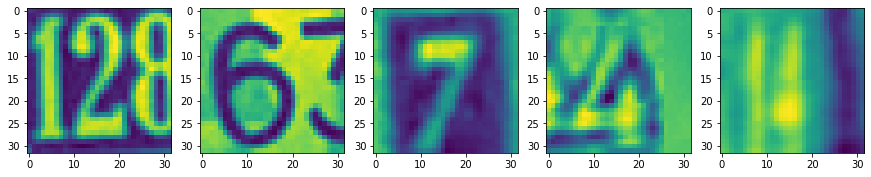

In [78]:
#visulaize first 5 images from the training dataset

print('The target values of first 5 images in the training dataset:', y_train[0:5] )

plt.figure(figsize=(15,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_train[i])

In [79]:
#get the unique number of target output in the training dataset
print('Unique values of target output:', np.unique(y_train))
print('Unique count of target output:', len(np.unique(y_train)))

Unique values of target output: [0 1 2 3 4 5 6 7 8 9]
Unique count of target output: 10


The target values of first 5 images in the testing dataset: [1 7 2 9 0]


<Figure size 1080x720 with 0 Axes>

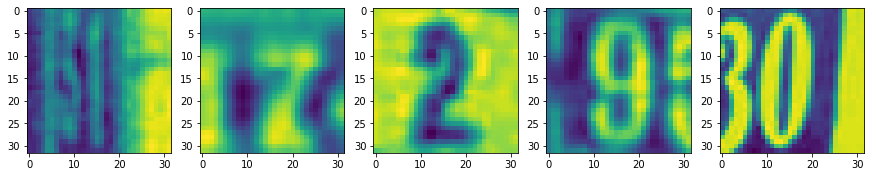

In [80]:
#visulaize first 5 images from the testing dataset

print('The target values of first 5 images in the testing dataset:', y_test[0:5] )

plt.figure(figsize=(15,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_test[i])

The target values of first 5 images in the validation dataset: [0 0 0 0 0]


<Figure size 1080x720 with 0 Axes>

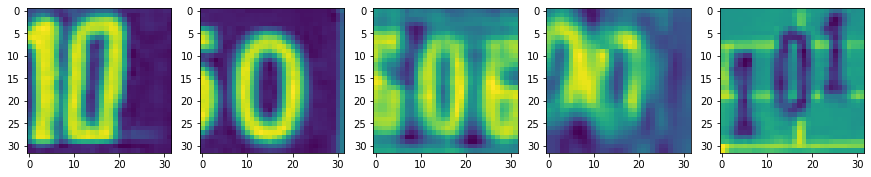

In [81]:
#visulaize first 5 images from the validation dataset

print('The target values of first 5 images in the validation dataset:', y_val[0:5] )

plt.figure(figsize=(15,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_val[i])

In [82]:
#Flatten train, test and validation datasets
X_train_flat = X_train.reshape(X_train.shape[0], -1)
print('The shape of training input features after reshape:', X_train_flat.shape)

X_test_flat = X_test.reshape(X_test.shape[0], -1)
print('The shape of testing input features after reshape:', X_test_flat.shape)

X_val_flat = X_val.reshape(X_val.shape[0], -1)
print('The shape of validation input features after reshape:', X_val_flat.shape)

The shape of training input features after reshape: (42000, 1024)
The shape of testing input features after reshape: (18000, 1024)
The shape of validation input features after reshape: (60000, 1024)


#### Check the statistics of each category

<Figure size 1008x360 with 0 Axes>

Text(0.5, 0, 'Train_Count')

Text(0.5, 0, 'Validation_Count')

Text(0.5, 0, 'Test_Count')

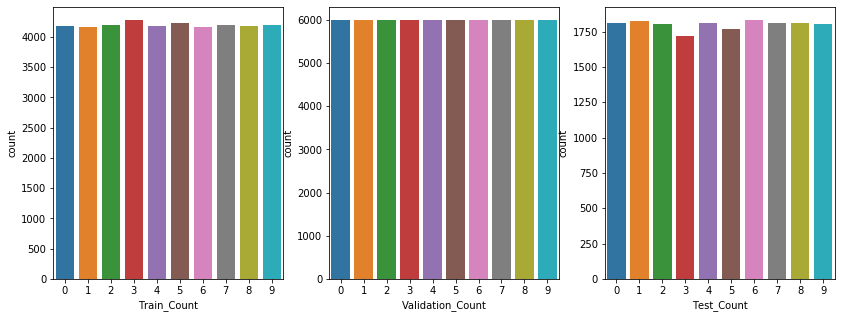

In [83]:
plt.figure(figsize=(14,5))
plt.subplot(1,3,1)
sns.countplot(y_train)
plt.xlabel('Train_Count')

plt.subplot(1,3,2)
sns.countplot(y_val)
plt.xlabel('Validation_Count')

plt.subplot(1,3,3)
sns.countplot(y_test)
plt.xlabel('Test_Count')

There is equal amount of records in all the categories

#### A simple neural network will be created using numpy and batch normalization also will be implemented

#### 1. Build Fully connected layer(linear layer)

In [28]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [29]:
import numpy as np 

class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * np.sqrt(2/in_size)
        self.b = np.zeros((1, out_size))
        self.gamma = np.ones((1, out_size))
        self.beta = np.zeros((1, out_size))
        self.params = [self.W, self.b, self.gamma, self.beta]
        self.gradW = None
        self.gradB = None
        self.gradgamma = None
        self.gradbeta = None
        self.gradInput = None    
        self.runninng_mean = 0
        self.running_var = 0

    def forward(self, X, mode, momentum):
        self.X = X
        self.Z = np.dot(X, self.W) + self.b 
        
        #Take running mean of the train which will be used during the testing
        if mode == 'train':
        
            #perform batch normalization in the forward pass
            self.mean = self.Z.mean(axis=0, keepdims = True)
            self.var = self.Z.var(axis=0, keepdims = True)  
        
            self.std = np.sqrt(self.var + 1e-7)        
                        
            self.X_centered = self.Z - self.mean       
            self.X_norm = self.X_centered / self.std         
            self.output =  (self.gamma * self.X_norm) + self.beta  
            
            self.running_mean = momentum * self.runninng_mean + (1 - momentum) * self.mean
            self.running_var = momentum * self.running_var + (1 - momentum) * self.var  
            
        else:
            self.X_norm = (self.Z - self.running_mean) / np.sqrt(self.running_var + 1e-7)
            self.output =  (self.gamma * self.X_norm) + self.beta
        
        return self.output

    def backward(self, nextgrad):
        N = nextgrad.shape[0]
        
        #backprop of batch normalization
        self.gradgamma = (nextgrad * self.X_norm).sum(axis=0)
        self.gradbeta = np.sum(nextgrad,axis=0)
        
        dx_norm = nextgrad * self.gamma
        dx_centered = dx_norm / self.std
        
        dmean = -(dx_centered.sum(axis=0) + 2/N * self.X_centered.sum(axis=0))
        dstd = (dx_norm * self.X_centered * -self.std**(-2)).sum(axis=0)
        dvar = dstd / 2 / self.std
        
        nextgrad = dx_centered + (dmean + dvar * 2 * self.X_centered) / N
        
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB, self.gradgamma, self.gradbeta]

#### 2. Build Rectified Linear Activation Layer (ReLU)

In [30]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X, mode, momentum):        
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

#### 3. Define the softmax function

In [31]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

#### 4. Define the Cross Entropy Loss

In [32]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y]+1e-16)
        loss = np.sum(cross_entropy) / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

In [34]:
#Flatten train, test and validation datasets
X_train = X_train.reshape(X_train.shape[0], -1)
print('\nThe shape of training input features after reshape:', X_train.shape)

X_test = X_test.reshape(X_test.shape[0], -1)
print('The shape of testing input features after reshape:', X_test.shape)

X_val = X_val.reshape(X_val.shape[0], -1)
print('The shape of validation input features after reshape:', X_val.shape)

X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

y_train.shape
y_test.shape
y_val.shape


The shape of training input features after reshape: (42000, 1024)
The shape of testing input features after reshape: (18000, 1024)
The shape of validation input features after reshape: (60000, 1024)


(42000,)

(18000,)

(60000,)

#### Here, we define the container NN class that enables the forward prop and backward propagation of the entire network. Note, how this class enables us to add layers of different types and also correctly pass gradients using the chain rule.

In [35]:
class NN():
    def __init__(self,mode,momentum,lossfunc=CrossEntropy()):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        self.mode = mode
        self.momentum = momentum 
        print(self.mode, self.momentum)
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X, mode, momentum):        
        for layer in self.layers:
            X = layer.forward(X, mode, momentum)          
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X, self.mode, self.momentum)
        loss = self.loss_func.forward(out,y)
        nextgrad = self.loss_func.backward(out,y)
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X, mode, momentum):
        X = self.forward(X, mode, momentum)
        p = softmax(X)
        return np.argmax(p, axis=1)
    
    def predict_scores(self, X, mode, momentum):
        X = self.forward(X, mode, momentum)
        p = softmax(X)
        return p
    
    def clear_grad_param(self):
        self.grads = []

#### Defining the update function (SGD with momentum)

In [36]:
def update_params(velocity, params, grads, beta1=0.9,learning_rate=0.01):
    
    for v, p, g, in zip(velocity, params, reversed(grads)):
        
        for i in range(len(g)):
            v[i] = beta1 * v[i] - learning_rate * g[i]
            p[i] += v[i]

#### Defining a function which gives us the minibatches (both the datapoint and the corresponding label)

In [37]:
# get minibatches
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))
        
    return minibatches

#### The traning loop

In [51]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, beta1=0.9, X_val=None, y_val=None):
    
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)       
        
    
                     
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []    
    
        for param_layer in net.params:
             p = [np.zeros_like(param) for param in list(param_layer)]         
             velocity.append(p)
                    
        # iterate over mini batches
        
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            m=X_mini.shape[0]            
            update_params(velocity,net.params, grads, beta1,learning_rate=learning_rate )

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = np.array([], dtype="int64")
        y_val_pred = np.array([], dtype="int64")
        y_train1 = []
        y_vall = []
        for i in range(0, m_train, minibatch_size):
            X_tr = X_train[i:i + minibatch_size, : ]
            y_tr = y_train[i:i + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr, mode='test', momentum=0.9))

        for i in range(0, m_val, minibatch_size):
            X_va = X_val[i:i + minibatch_size, : ]
            y_va = y_val[i:i + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va, mode='test', momentum=0.9))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)

        mean_train_loss = sum(loss_batch) / float(len(loss_batch))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net

#### Checking the accuracy of the model

In [52]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

### Invoking all that we have created until now

In [53]:
from random import shuffle

## input size
input_dim = X_train.shape[1]

## hyperparameters
iterations = 10
learning_rate = 0.001
hidden_nodes = 100
output_nodes = 10

## define neural net
nn = NN(mode='train', momentum=0.9)
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(ReLU())
# nn.add_layer(Linear(hidden_nodes, hidden_nodes))
# nn.add_layer(ReLU())
nn.add_layer(Linear(hidden_nodes, output_nodes))

nn = train(nn, X_train , y_train, minibatch_size=200, epoch=30, \
           learning_rate=learning_rate, X_val=X_val, y_val=y_val)

train 0.9
Loss = 2.3503189958931388 | Training Accuracy = 0.20626190476190476 | Val Loss = 1.991334709048611 | Val Accuracy = 0.2058
Loss = 1.8491532617349087 | Training Accuracy = 0.36642857142857144 | Val Loss = 1.667592576041684 | Val Accuracy = 0.36606666666666665
Loss = 1.584047798612041 | Training Accuracy = 0.4714285714285714 | Val Loss = 1.4703176222824335 | Val Accuracy = 0.4703833333333333
Loss = 1.4258263233050232 | Training Accuracy = 0.5573571428571429 | Val Loss = 1.3465263471271847 | Val Accuracy = 0.556
Loss = 1.3172784312602783 | Training Accuracy = 0.598547619047619 | Val Loss = 1.2540240499757647 | Val Accuracy = 0.5956
Loss = 1.2338800263093024 | Training Accuracy = 0.6205714285714286 | Val Loss = 1.183324428895783 | Val Accuracy = 0.6182833333333333
Loss = 1.1648316095178861 | Training Accuracy = 0.6415714285714286 | Val Loss = 1.1242887649313555 | Val Accuracy = 0.6387
Loss = 1.1062258553209459 | Training Accuracy = 0.6557142857142857 | Val Loss = 1.07828310318289

In [54]:
predict_train = nn.predict(X_train, mode='test', momentum=0.9)
predict_val = nn.predict(X_val, mode='test', momentum=0.9)
predict_test = nn.predict(X_test, mode='test', momentum=0.9)

In [55]:
accuracy_df = pd.DataFrame([], columns = [['train_score', 'validation_score', 'test_F1_score']])

In [56]:
accuracy_df.loc['NN-Numpy', 'train_score'] = f1_score(y_train, predict_train, average='weighted')
accuracy_df.loc['NN-Numpy', 'validation_score'] = f1_score(y_val, predict_val, average='weighted')
accuracy_df.loc['NN-Numpy', 'test_F1_score'] = f1_score(y_test, predict_test, average='weighted')

In [57]:
accuracy_df

,train_score,validation_score,test_F1_score
NN-Numpy,0.754059,0.747303,0.731551


Inference:           
1) 'He normalization' is used to initialize the weights.                         
2) Gradient moment is used as optimization technique to increase the learning rate.               
3) Batch normalization has been used to prevent the internal covariance shift and this it enhances the learning process.    
4) Because of the introduction of batch normalization, a small noise has been introduced into the system and thus it gave a small regularization effect and thus it prevented the overfitting problem.      
5) For 30 epochs , an accuracy level of 73% can be noticed.

In [84]:
#convert y to to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

#### Model1 => A simple model without any alterations

In [85]:
model = Sequential()

In [86]:
model.add(Dense(50, input_shape = (1024, )))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [87]:
sgd = optimizers.SGD(lr = 0.01)
model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [88]:
model.fit(X_train_flat, y_train, validation_data = (X_val_flat, y_val), batch_size = 256, epochs = 30, verbose = 0)

predict_y = model.predict(X_test_flat)
predict_value = predict_y.argmax(axis=1)
actual_value = y_test.argmax(axis=1)

accuracy_df.loc['simple_sigmoid', 'train_score'] = model.evaluate(X_train_flat, y_train, verbose=0)[1]
accuracy_df.loc['simple_sigmoid', 'validation_score'] = model.evaluate(X_val_flat, y_val, verbose=0)[1]
accuracy_df.loc['simple_sigmoid', 'test_F1_score'] = f1_score(actual_value, predict_value, average='weighted')

In [89]:
accuracy_df.loc['simple_sigmoid']

train_score         0.0999524
validation_score       0.1001
test_F1_score       0.0185584
Name: simple_sigmoid, dtype: object

Inference: Using a sigmoid function with a simple model performs poorly on the dataset

#### Model2 => Enhancement done to weight intiliaztion technique

In [90]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(50, input_shape = (1024, ), kernel_initializer='he_normal'))     # use he_normal initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(50, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('sigmoid'))    
    model.add(Dense(10, kernel_initializer='he_normal'))                            # use he_normal initializer
    model.add(Activation('softmax'))
    
    sgd = optimizers.SGD(lr = 0.001)
    model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [91]:
model = mlp_model()

model.fit(X_train_flat, y_train, validation_data = (X_val_flat, y_val), batch_size = 256, epochs = 30, verbose = 0)

predict_y = model.predict(X_test_flat)
predict_value = predict_y.argmax(axis=1)
actual_value = y_test.argmax(axis=1)

accuracy_df.loc['sigmoid_weight_imp', 'train_score'] = model.evaluate(X_train_flat, y_train, verbose=0)[1]
accuracy_df.loc['sigmoid_weight_imp', 'validation_score'] = model.evaluate(X_val_flat, y_val, verbose=0)[1]
accuracy_df.loc['sigmoid_weight_imp', 'test_F1_score'] = f1_score(actual_value, predict_value, average='weighted')

In [92]:
accuracy_df

,train_score,validation_score,test_F1_score
NN-Numpy,0.754059,0.747303,0.731551
simple_sigmoid,0.0999524,0.1001,0.0185584
sigmoid_weight_imp,0.113357,0.111717,0.0652394


Inferenece: The weight initialization has improvised the test score a little but not a big change

#### Model3 => using Non linear function ReLU.
Since sigmoid and tanh suffer from vanishing gradient problem where there is no learning at higher positive and negative side

In [93]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(200, input_shape = (1024, ), kernel_initializer='he_normal'))
    model.add(Activation('relu'))    
    model.add(Dense(200, kernel_initializer='he_normal'))
    model.add(Activation('relu'))    
    model.add(Dense(200, kernel_initializer='he_normal'))
    model.add(Activation('relu'))    
    model.add(Dense(200, kernel_initializer='he_normal'))
    model.add(Activation('relu'))    
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    sgd = optimizers.SGD(lr = 0.001)
    model.compile(optimizer = sgd, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [94]:
model = mlp_model()

model.fit(X_train_flat, y_train, validation_data = (X_val_flat, y_val), batch_size = 256, epochs = 30, verbose = 0)

predict_y = model.predict(X_test_flat)
predict_value = predict_y.argmax(axis=1)
actual_value = y_test.argmax(axis=1)

accuracy_df.loc['simple_ReLU', 'train_score'] = model.evaluate(X_train_flat, y_train, verbose=0)[1]
accuracy_df.loc['simple_ReLU', 'validation_score'] = model.evaluate(X_val_flat, y_val, verbose=0)[1]
accuracy_df.loc['simple_ReLU', 'test_F1_score'] = f1_score(actual_value, predict_value, average='weighted')

In [95]:
accuracy_df

,train_score,validation_score,test_F1_score
NN-Numpy,0.754059,0.747303,0.731551
simple_sigmoid,0.0999524,0.1001,0.0185584
sigmoid_weight_imp,0.113357,0.111717,0.0652394
simple_ReLU,0.102143,0.1002,0.0171008


Inference: Simple_ReLU also does not improve the performance to a greater extent.

#### Model4 => using Non linear function ReLU with batch normalization and adam optimizer

In [96]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(200, input_shape = (1024, ), kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(200, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu')) 
    model.add(Dense(200, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(200, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))          
    model.add(Dense(10, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [97]:
model = mlp_model()

model.fit(X_train_flat, y_train, validation_data = (X_val_flat, y_val), batch_size = 256, epochs = 30, verbose = 0)

predict_y = model.predict(X_test_flat)
predict_value = predict_y.argmax(axis=1)
actual_value = y_test.argmax(axis=1)

accuracy_df.loc['ReLU_Adam_norm', 'train_score'] = model.evaluate(X_train_flat, y_train, verbose=0)[1]
accuracy_df.loc['ReLU_Adam_norm', 'validation_score'] = model.evaluate(X_val_flat, y_val, verbose=0)[1]
accuracy_df.loc['ReLU_Adam_norm', 'test_F1_score'] = f1_score(actual_value, predict_value, average='weighted')

In [98]:
accuracy_df

,train_score,validation_score,test_F1_score
NN-Numpy,0.754059,0.747303,0.731551
simple_sigmoid,0.0999524,0.1001,0.0185584
sigmoid_weight_imp,0.113357,0.111717,0.0652394
simple_ReLU,0.102143,0.1002,0.0171008
ReLU_Adam_norm,0.724976,0.70755,0.681323


Inference:                  
1) Batch normalization before each activation layer prevents the data from covariance shift problem and also the statistics
   mean=0  and standard deviation=1 are maintained to some level per the normal distribution.             
   
2) Adam optimizer enhances the learning process by taking bigger steps in the saddle points and also reduces the oscillations 
   thus convergence towards global minima happens in a better way.          
   
3) When we compare the training score and test score, it looks like overfitting. We can introduce, droupout regularization to check the impact on the results.             

In [99]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(200, input_shape = (1024, ), kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(200, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(200, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(200, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))                
    model.add(Dense(10, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [100]:
model = mlp_model()

In [101]:
model.fit(X_train_flat, y_train, validation_data = (X_val_flat, y_val), batch_size = 256, epochs = 30, verbose = 0)

predict_y = model.predict(X_test_flat)
predict_value = predict_y.argmax(axis=1)
actual_value = y_test.argmax(axis=1)

accuracy_df.loc['ReLU_Dropout', 'train_score'] = model.evaluate(X_train_flat, y_train, verbose=0)[1]
accuracy_df.loc['ReLU_Dropout', 'validation_score'] = model.evaluate(X_val_flat, y_val, verbose=0)[1]
accuracy_df.loc['ReLU_Dropout', 'test_F1_score'] = f1_score(actual_value, predict_value, average='weighted')

In [102]:
accuracy_df

,train_score,validation_score,test_F1_score
NN-Numpy,0.754059,0.747303,0.731551
simple_sigmoid,0.0999524,0.1001,0.0185584
sigmoid_weight_imp,0.113357,0.111717,0.0652394
simple_ReLU,0.102143,0.1002,0.0171008
ReLU_Adam_norm,0.724976,0.70755,0.681323
ReLU_Dropout,0.630714,0.623483,0.629052


Inference:             
1) Since dropout has the tendency to randomly turn off the neurons, the learning process is not solely depends on one particular node. 

2) In case of dropout, the weights are spread across each and every neuron so the all the neurons gain equal importance. 
Since removing some of the nodes will result in a medium level model and not the complex model. 

3) So, the dropout regularization greatly assits in preventing the overfitting.

In [103]:
#increaing the epoch to the ReLU_Dropout

model.fit(X_train_flat, y_train, validation_data = (X_val_flat, y_val), batch_size = 256, epochs = 100, verbose = 0)

predict_y = model.predict(X_test_flat)
predict_value = predict_y.argmax(axis=1)
actual_value = y_test.argmax(axis=1)

accuracy_df.loc['ReLU_Dropout_epoch100', 'train_score'] = model.evaluate(X_train_flat, y_train, verbose=0)[1]
accuracy_df.loc['ReLU_Dropout_epoch100', 'validation_score'] = model.evaluate(X_val_flat, y_val, verbose=0)[1]
accuracy_df.loc['ReLU_Dropout_epoch100', 'test_F1_score'] = f1_score(actual_value, predict_value, average='weighted')

In [105]:
accuracy_df

,train_score,validation_score,test_F1_score
NN-Numpy,0.754059,0.747303,0.731551
simple_sigmoid,0.0999524,0.1001,0.0185584
sigmoid_weight_imp,0.113357,0.111717,0.0652394
simple_ReLU,0.102143,0.1002,0.0171008
ReLU_Adam_norm,0.724976,0.70755,0.681323
ReLU_Dropout,0.630714,0.623483,0.629052
ReLU_Dropout_epoch100,0.868333,0.849417,0.807098


Inference: As we increase the number of epochs (i.e) number of times the entire training data is trianed, 
           F1_score of the test dataset has greatly improvised.     
           
Conclusion:                
A Neural network gives better prediction when the below details are included:             
1) Using Non-linear activation functions like ReLU.            
2) When using ReLU, He_normal weight initialization technique is used. As the ReLU function value is zero when the input value is negative.                  
3) Batch Normalization greatly improved the model accuracy by preventing the internal covariance shift.        
4) Dropout is a regularization technique to prevent the model from overfitting.         
5) To have considerable number of iterations(epoch).
